In [3]:
import os
import sys
HOME = os.path.abspath('../src')
sys.path.append(HOME)
os.chdir(HOME)

In [5]:
import torchvision
import dlib
from PIL import Image
from imutils import face_utils
from data.dataprep_mediapipe import VideoProcessor
from data.imgutils import *
from features.features_extractors_mediapipe import *
import pandas as pd
import seaborn as sns

In [9]:
os.getcwd()

'/Users/samirchar/Google_Drive/Masters/DSI Scholars/stroke_detection'

In [8]:
FILTER = 'face_smile'
IMG_SIZE = 224
input_directory = '../data/raw'
output_directory = '../data/processed'
video_processor = VideoProcessor(input_directory,
                                 output_directory)

patiend_ids = set([int(i.split('_')[0]) for i in video_processor.video_filter(input_directory,video_type=FILTER)])
processed_ids = set([int(i.split('_')[0]) for i in video_processor.video_filter(output_directory,extension='pkl',video_type=FILTER)])
remaining_ids = patiend_ids-processed_ids


In [9]:
remaining_ids

{65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81}

In [11]:
p_id = next(iter(remaining_ids))

video_processor = VideoProcessor(input_directory,
                                 output_directory)
video_names = video_processor.video_filter(input_directory,p_id)
video_processor.read(video_names)


In [12]:
video_processor.pre_process()

In [5]:
'''
left_magnitudes_temp_flipped = [cv2.flip(i,1) for i in left_magnitudes_temp]

right_magnitudes_temp_cropped = []
for i in range(len(left_magnitudes_temp_flipped)):
    hlf,wlf = left_magnitudes_temp_flipped[i].shape
    hrf,wrf = right_magnitudes_temp[i].shape
    h_i = min(hlf,hrf)
    w_i = min(wlf,wrf)
    
    right_magnitudes_temp_cropped.append(right_magnitudes_temp[i][:h_i,:w_i])

bilateral_differences = [l-r for l,r in zip(left_magnitudes_temp_flipped,right_magnitudes_temp_cropped)]
'''

'\nleft_magnitudes_temp_flipped = [cv2.flip(i,1) for i in left_magnitudes_temp]\n\nright_magnitudes_temp_cropped = []\nfor i in range(len(left_magnitudes_temp_flipped)):\n    hlf,wlf = left_magnitudes_temp_flipped[i].shape\n    hrf,wrf = right_magnitudes_temp[i].shape\n    h_i = min(hlf,hrf)\n    w_i = min(wlf,wrf)\n    \n    right_magnitudes_temp_cropped.append(right_magnitudes_temp[i][:h_i,:w_i])\n\nbilateral_differences = [l-r for l,r in zip(left_magnitudes_temp_flipped,right_magnitudes_temp_cropped)]\n'

# Run all Video V2

In [6]:
import cv2
import time


def extract_features(processed_video_path,optical_flow_threshold = 3):

    #Init
    rfev2 = ROIFlowExtractorV2(optical_flow_threshold)

    video_iterator = iter(read_pickle(processed_video_path))

    first_frame = next(video_iterator)
    frame_prev,face_prev  = first_frame['frame'],first_frame['face_data']
    h,w,_ = frame_prev.shape
    processed_landmarks_prev = face_prev['processed_landmarks']

    left_of_frames = []
    right_of_frames = []
    frames_drawn = []
    all_face_objs = []

    #OF first, then crop
    lm_scores = []
    rm_scores = [] 

    face_mags = []
    face_mags_filtered = []
    
    head_pose = []
    processed_landmarks_normalized_sequence = [face_prev['processed_landmarks_normalized_v2']]

    for processed_frame in video_iterator:

        frame,face  = processed_frame['frame'],processed_frame['face_data']

        processed_landmarks_normalized_sequence.append(face['processed_landmarks_normalized_v2'])
        processed_landmarks = face['processed_landmarks']
        
        head_pose.append(face['pose'])

        #OF Movement V2:
        rfev2.face_flow(frame_prev,frame)
        rfev2.all_regions_movement(processed_landmarks,['mouth'])

        # Updates previous frame info
        frame_prev = frame.copy()
        face_prev = face.copy()
        processed_landmarks_prev = processed_landmarks.copy()

    bac = BarycentricAsymmetryCalculator()

    asymmetry_index_df = bac.get_indexes_video(processed_landmarks_normalized_sequence)
    asymmetry_stats = bac.get_indexes_stats_video(asymmetry_index_df)
    movement_df = rfev2.to_df()

    temp = pd.DataFrame([[np.nan] * len(movement_df.columns)], columns=movement_df.columns)
    movement_df = temp.append(movement_df, ignore_index=True)
    
    head_pose_df = pd.DataFrame(head_pose,columns=['pitch','yaw','roll'])
    df = pd.concat([movement_df,asymmetry_index_df,head_pose_df],axis=1)
    
    return df

In [13]:
video_list = video_processor.video_filter(output_directory,
                                          extension='pkl',
                                          video_type='face_smile',
                                          #patient_id=3
                                         )

In [15]:
df = []
c=1
num_videos = len(video_list)
for v in video_list:
    df_temp = extract_features(os.path.join(output_directory,v))
    df_temp['video_name'] = v
    print(c*100/num_videos)
    c+=1
    df.append(df_temp)
df = pd.concat(df)

1.3333333333333333
2.6666666666666665
4.0
5.333333333333333
6.666666666666667
8.0
9.333333333333334
10.666666666666666
12.0
13.333333333333334
14.666666666666666
16.0
17.333333333333332
18.666666666666668
20.0
21.333333333333332
22.666666666666668
24.0
25.333333333333332
26.666666666666668
28.0
29.333333333333332
30.666666666666668
32.0
33.333333333333336
34.666666666666664
36.0
37.333333333333336
38.666666666666664
40.0
41.333333333333336
42.666666666666664
44.0
45.333333333333336
46.666666666666664
48.0
49.333333333333336
50.666666666666664
52.0
53.333333333333336
54.666666666666664
56.0
57.333333333333336
58.666666666666664
60.0
61.333333333333336
62.666666666666664


ModuleNotFoundError: No module named 'data.dataprep_mediapipe'

In [ ]:
motion_maxes = df.groupby('video_name')['mouth_left','mouth_right'].max().max(axis=1).reset_index()
temp = df.merge(motion_maxes,how='left',on='video_name')
df['mouth_left'] = df['mouth_left']/temp[0].values
df['mouth_right'] = df['mouth_right']/temp[0].values

In [ ]:
df['mouth_motion_abs_diff'] = (df['mouth_left']-df['mouth_right']).abs()

In [ ]:
df_stats1 = df.groupby('video_name')[['mouth','pitch','yaw','roll']].describe()
df_stats3 = df.groupby('video_name')['mouth_left','mouth_right','mouth_motion_abs_diff'].apply(lambda x: x[x>0].describe()).unstack()

df_stats1.columns = ['_'.join(col).strip() for col in df_stats1.columns.values]
df_stats3.columns = ['_'.join(col).strip() for col in df_stats3.columns.values]

df_stats = pd.concat([df_stats1,df_stats3],axis=1)

cols =[i for i in df_stats.columns if ('count' not in i)&('mouth_left' not in i)&('mouth_right' not in i)&('mouth_motion' not in i)]
df_stats = df_stats[cols]


In [ ]:
df_stats['mouth_p2a'] = df_stats['mouth_max']/df_stats['mouth_mean']

In [ ]:
df_stats['mouth_p2m'] = df_stats['mouth_max']/df_stats['mouth_min']

In [1118]:
df_fast = pd.read_csv('data/raw/FASTr_DATA_2022-.csv')
df_fast.sort_index(inplace=True)

df_stats.reset_index(inplace=True)
df_stats['record_id'] = df_stats['video_name'].apply(lambda x: int(x.split('_')[0]))

df_stats = df_stats.merge(df_fast[['f_ground_truth','record_id']],how = 'left',on='record_id')

df_stats.sort_values(by='record_id',inplace=True)

vars_ = df_stats.columns.drop(['f_ground_truth','record_id','video_name'])

df_stats_norm = df_stats.copy()
df_stats_norm[vars_] = (df_stats[vars_] - df_stats[vars_].mean())/df_stats[vars_].std()

In [1119]:
df_stats_norm = df_stats_norm[df_stats_norm.isna().all().index[~df_stats_norm.isna().all()]]
df_stats_norm = df_stats_norm[~df_stats_norm.isna().any(axis=1)]
#df_stats_norm.sort_index(inplace=True)

<AxesSubplot:xlabel='f_ground_truth', ylabel='mouth_75%'>

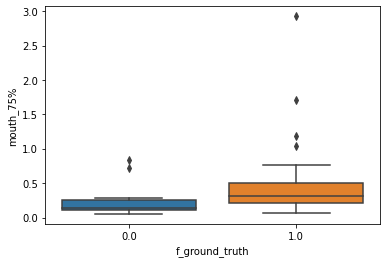

In [1125]:
sns.boxplot(data = df_stats_norm,
            y=df_stats['mouth_75%'],
            x='f_ground_truth')

#plt.ylim(-5,10)

<AxesSubplot:xlabel='f_ground_truth', ylabel='mouth_max'>

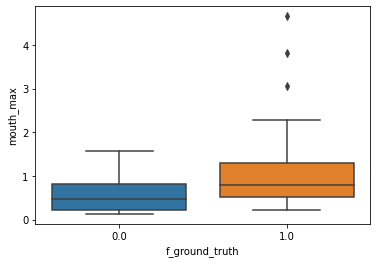

In [1126]:
sns.boxplot(data = df_stats_norm,
            y=df_stats['mouth_max'],
            x='f_ground_truth')

#plt.ylim(-5,20)

<AxesSubplot:xlabel='f_ground_truth', ylabel='mouth_p2a'>

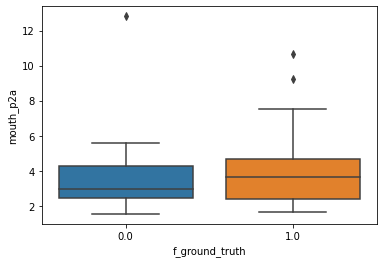

In [1127]:
sns.boxplot(data = df_stats,y='mouth_p2a',x='f_ground_truth')

<AxesSubplot:xlabel='f_ground_truth', ylabel='mouth_p2m'>

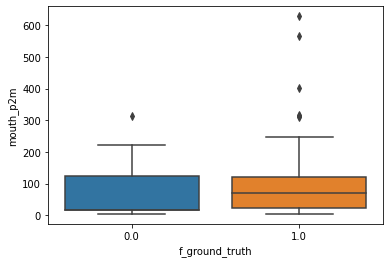

In [1128]:
sns.boxplot(data = df_stats,y='mouth_p2m',x='f_ground_truth')

In [1129]:
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split, KFold,cross_val_predict,cross_validate,StratifiedKFold
from sklearn.metrics import roc_auc_score,recall_score,precision_score,balanced_accuracy_score,f1_score,make_scorer
from itertools import product

In [1130]:
class MyLR(LogisticRegression):
    def __init__(self,pred_threshold=0.5,**kwargs):
        super(MyLR,self).__init__(**kwargs)
        self.pred_threshold = pred_threshold
        
    def predict(self,X,**kwargs):
        result = super(MyLR, self).predict_proba(X, **kwargs)
        predictions = [1 if p>self.pred_threshold else 0 for p in result[:,1]]
        return predictions

In [1194]:
def cross_val_score_th(clf,
                       X_train_,
                       y_train_,
                       prediction_threshold,
                       metric_fun,
                       cv = 10,
                       shuffle = True,
                       random_state = 1
                       ):
    
    X_train = X_train_.copy()
    y_train = y_train_.copy()
    
    if isinstance(X_train,pd.DataFrame)|isinstance(X_train,pd.Series):
        X_train = X_train.values
        
    if isinstance(y_train,pd.Series):
        y_train = y_train.values
        
    kf = StratifiedKFold(n_splits=cv,shuffle = shuffle,random_state = random_state)
    kf.get_n_splits(X_train)
    
    scores = []
    for train_index, test_index in kf.split(X_train,y_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        
        clf.fit(X_train_cv,y_train_cv)
        y_preds_proba = clf.predict_proba(X_test_cv)
        y_preds = (y_preds_proba[:,1]>prediction_threshold)*1
        
        score = metric_fun(y_test_cv,y_preds)
        
        scores.append(score)
        
    return np.array(scores)


cs = np.arange(0.01,3,0.1)
ths = np.arange(.05,.9,0.05)
hparams = [cs,ths]
combs = list(product(*hparams))

#na = df_stats_norm['f_ground_truth'].isna()
X = df_stats_norm[[ 'record_id',
                    'mouth_25%',
                    'mouth_50%',
                    'mouth_75%',
                    'mouth_max',
                    'mouth_p2a',
                    #'mouth_p2m',
                    #'pitch_mean',
                    # 'pitch_max',
                    #'yaw_mean',
                    #'yaw_max'
                       ]]

y= df_stats_norm['f_ground_truth']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


scores = []
for c,th in combs:

    lr = LogisticRegression(C=c,
              max_iter=1000,
              random_state=1,
              class_weight='balanced')

    #lr.fit(X_train,y_train)

    #preds =lr.predict(X_test)
    
    cv_scores = cross_val_score_th(lr,X_train.drop('record_id',axis=1),y_train,th,balanced_accuracy_score,cv=5)
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()
    scores.append(mean_score)
    

In [1195]:
best_comb_id = np.argmax(scores)
print(combs[best_comb_id],scores[best_comb_id])


best_c,best_th = combs[best_comb_id]

(0.81, 0.4) 0.6566666666666665


In [1196]:
lr = LogisticRegression(C=best_c,
          max_iter=1000,
          random_state=1,
          class_weight='balanced')
lr.fit(X_train.drop('record_id',axis=1),y_train)

LogisticRegression(C=0.81, class_weight='balanced', max_iter=1000,
                   random_state=1)

In [1197]:
prediction_threshold = best_th
y_preds = (lr.predict_proba(X_test.drop('record_id',axis=1))[:,1]>prediction_threshold)*1


In [1199]:
print('balanced_accuracy_score:',balanced_accuracy_score(y_test.values,y_preds))
print('precision :',precision_score(y_test.values,y_preds))
print('sensitivity/recall :',recall_score(y_test.values,y_preds))
print('specificity :',recall_score(y_test.values,y_preds,pos_label=0))


balanced_accuracy_score: 0.7857142857142857
precision : 1.0
sensitivity/recall : 0.5714285714285714
specificity : 1.0


In [1200]:
y_preds

array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0])

In [1202]:
y_test.values

array([0., 0., 1., 1., 1., 1., 0., 1., 1., 1.])